# Re-Ordering

## Description
Activities are performed by agents in a sequence that runs contrary to regulations, best practice, or to what is prescribed in the process model.

In [60]:
import pandas as pd
import numpy as np
import altair as alt
alt.data_transformers.enable('vegafusion')
import pm4py

In [61]:
ref_log_name = 'propr_ref'
test_log_name = 'propr_test'

fn_logs = {
    'bpic15': '../data/preproc/bpic15.csv',
    'bpic15_ref': '../data/preproc/bpic15_train-70.csv',
    'bpic15_test': '../data/preproc/bpic15_test-30.csv',

    'bpic17': '../data/preproc/bpic2017.csv',

    'propr': '../data/preproc/proprietary.csv',
    'propr_ref': '../data/preproc/proprietary_train-70.csv',
    'propr_test': '../data/preproc/proprietary_test-30.csv'
}

In [62]:
log_ref = pd.read_csv(fn_logs[ref_log_name])
print(log_ref['case_id'].nunique())
log_ref = pm4py.format_dataframe(
    log_ref, 
    case_id='case_id', 
    activity_key='activity', 
    timestamp_key='complete timestamp',
    start_timestamp_key='start timestamp'
)
log_ref = pm4py.convert_to_event_log(log_ref)
log_ref

1212


[{'attributes': {'concept:name': '005141EEB1240B31C12577DF004F6A77'}, 'events': [{'activity': 'Processing_of_Applications', 'case_id': '005141EEB1240B31C12577DF004F6A77', 'start timestamp': Timestamp('2010-02-12 10:46:00+0000', tz='UTC'), 'complete timestamp': Timestamp('2010-02-12 10:46:00+0000', tz='UTC'), 'resource': '010-23-11', 'Weekday': 'Thursday', 'School holidays; 0 = no, 1 = yes': 0.0, 'Approval; 1 = low sum to 4 = high sum': 2.0, 'Type of loan; 0 = normal; 1 = special': 0.0, 'Cost': '1,02 € per minute', '_start timestamp': Timestamp('2010-12-02 10:46:00+0000', tz='UTC'), '_complete timestamp': Timestamp('2010-12-02 10:46:00+0000', tz='UTC'), 'concept:name': 'Processing_of_Applications', 'time:timestamp': Timestamp('2010-02-12 10:46:00+0000', tz='UTC'), '@@index': 0, '@@case_index': 0, 'start_timestamp': Timestamp('2010-02-12 10:46:00+0000', tz='UTC')}, '..', {'activity': 'Check_of_Processing_Applications', 'case_id': '005141EEB1240B31C12577DF004F6A77', 'start timestamp': Tim

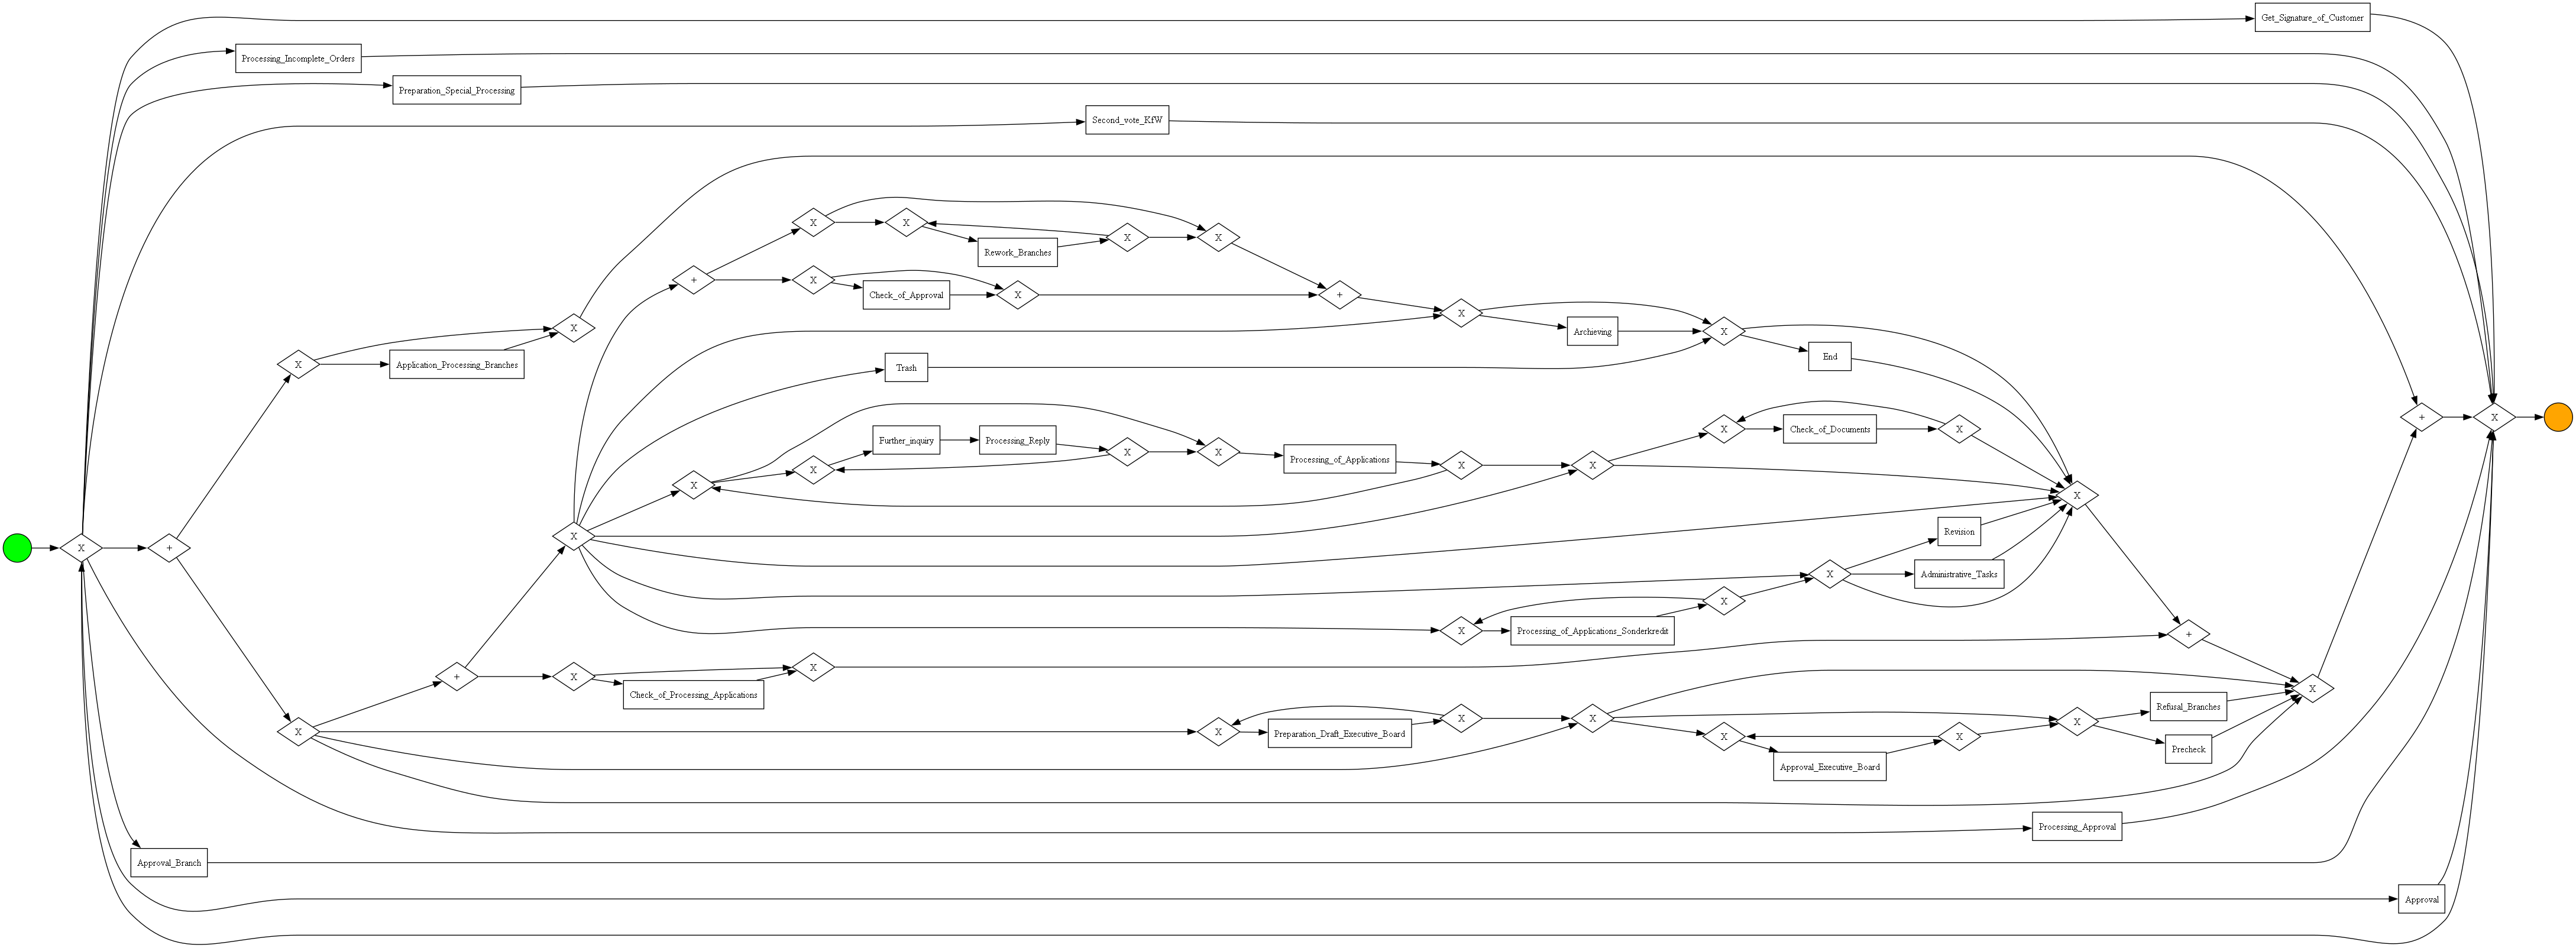

In [63]:
net, im, fm = pm4py.discover_petri_net_inductive(
    log_ref
)
# net
bpmn = pm4py.convert_to_bpmn(net, im, fm)
pm4py.view_bpmn(bpmn, format='png')

In [64]:
log_test = pd.read_csv(fn_logs[test_log_name])
print(log_test['case_id'].nunique())
log_test
log_test = pm4py.format_dataframe(
    log_test, 
    case_id='case_id', 
    activity_key='activity', 
    timestamp_key='complete timestamp',
    start_timestamp_key='start timestamp'
)
el_log_test = pm4py.convert_to_event_log(log_test)
el_log_test

519


[{'attributes': {'concept:name': '0051574BDF30D681C1257888004DC40D'}, 'events': [{'activity': 'Processing_of_Applications', 'case_id': '0051574BDF30D681C1257888004DC40D', 'start timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC'), 'complete timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC'), 'resource': '010-25-07', 'Weekday': 'Wednesday', 'School holidays; 0 = no, 1 = yes': 0.0, 'Approval; 1 = low sum to 4 = high sum': 1.0, 'Type of loan; 0 = normal; 1 = special': 0.0, 'Cost': '1,02 € per minute', '_start timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC'), '_complete timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC'), 'concept:name': 'Processing_of_Applications', 'time:timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC'), '@@index': 0, '@@case_index': 0, 'start_timestamp': Timestamp('2011-05-18 09:18:00+0000', tz='UTC')}, '..', {'activity': 'Check_of_Processing_Applications', 'case_id': '0051574BDF30D681C1257888004DC40D', 'start timestamp': Ti

In [65]:
problematic_cases = pm4py.conformance_diagnostics_token_based_replay(
    el_log_test, 
    net, im, fm,
    return_diagnostics_dataframe=True
)
problematic_cases = list(
    problematic_cases.loc[problematic_cases['trace_fitness'] < 1, 'case_id'].values
)

print('{} of {} cases in the log have conformance problems with fitness < 1'.format(
    len(problematic_cases), log_test['case_id'].nunique()
))

log_test_sel = log_test[log_test['case_id'].isin(problematic_cases)]

for case_id, trace in log_test[log_test['case_id'].isin(problematic_cases)].groupby('case_id'):
    print('case_id {} has fitness < 1. Transition with problems:'.format(case_id), end=' ')
    tbr = pm4py.conformance_diagnostics_token_based_replay(
        trace,
        net, im, fm,
        case_id_key='case_id', 
        activity_key='activity', 
        timestamp_key='complete timestamp'
    )
    print(tbr[0]['transitions_with_problems'])
    print(trace['activity'].tolist())
    # manual test of a case
    # if case_id == '019BA943BC4EFEF2C125784E0033FDDE':
    #     modified_trace = pd.concat([
    #         trace,
    #         pd.DataFrame([
    #             {'activity': 'Refusal_Branches', 'case_id': case_id, 'complete timestamp': pd.Timestamp('2011-11-03 11:59:00+00:00')}
    #         ])
    #     ])
    #     # print(modified_trace)
    #     new_tbr = pm4py.conformance_diagnostics_token_based_replay(
    #         modified_trace,
    #         net, im, fm,
    #         case_id_key='case_id', 
    #         activity_key='activity', 
    #         timestamp_key='complete timestamp',
    #         return_diagnostics_dataframe=True
    #     )
    #     print(new_tbr)
        

# tbr_diagnostics[tbr_diagnostics['is_fit'] == False]

replaying log with TBR, completed traces ::   0%|          | 0/432 [00:00<?, ?it/s]

replaying log with TBR, completed traces :: 100%|██████████| 432/432 [00:00<00:00, 471.52it/s]


2 of 519 cases in the log have conformance problems with fitness < 1
case_id 019BA943BC4EFEF2C125784E0033FDDE has fitness < 1. Transition with problems: []
['Precheck', 'Precheck', 'Application_Processing_Branches', 'Application_Processing_Branches', 'Application_Processing_Branches', 'Approval_Branch', 'Precheck', 'Application_Processing_Branches', 'Precheck', 'Precheck', 'Check_of_Processing_Applications', 'Processing_of_Applications', 'Processing_of_Applications', 'Archieving', 'End', 'Approval_Branch', 'Preparation_Draft_Executive_Board', 'Approval_Branch', 'Approval_Executive_Board']
case_id 635A8C14C5F4B799C1257872002D1BC9 has fitness < 1. Transition with problems: [(f859494e-624a-45ca-bd2c-d3ef3a672bc6, 'Further_inquiry'), (f859494e-624a-45ca-bd2c-d3ef3a672bc6, 'Further_inquiry')]
['Precheck', 'Check_of_Processing_Applications', 'Check_of_Processing_Applications', 'Check_of_Processing_Applications', 'Check_of_Processing_Applications', 'Check_of_Processing_Applications', 'Further

In [66]:
# problematic_cases = pm4py.conformance_diagnostics_alignments(
#     el_log_test, 
#     net, im, fm,
#     multi_processing=True,
#     return_diagnostics_dataframe=True
# )
# problematic_cases = list(
#     problematic_cases.loc[problematic_cases['fitness'] < 1, 'case_id'].values
# )

# print('{} of {} cases in the log have conformance problems with fitness < 1'.format(
#     len(problematic_cases), log_test['case_id'].nunique()
# ))

# log_test_sel = log_test[log_test['case_id'].isin(problematic_cases)]

# for case_id, trace in log_test[log_test['case_id'].isin(problematic_cases)].groupby('case_id'):
#     print('case_id {} has fitness < 1. Alignments:'.format(case_id))
#     alignments = pm4py.conformance_diagnostics_alignments(
#         trace,
#         net, im, fm,
#         case_id_key='case_id', 
#         activity_key='activity', 
#         timestamp_key='complete timestamp'
#     )
#     print(alignments[0]['alignment'])

# alignment_diagnostics[alignment_diagnostics['is_fit'] == False]